In [1]:
import numpy as np

from optyx.core.channel import Ty
from optyx.qubits import *

from optyx import (
    bit,
    Channel,
    Diagram,
    CQMap,
    Discard as DiscardChannel
)

In [2]:

Ket_0 = Ket(0)
Ket_1 = Ket(1)

Ket_plus = Ket("+")
Ket_minus = Ket("-")

Bra_0 = Bra(0)
Bra_1 = Bra(1)

Bra_plus = Bra("+")
Bra_minus = Bra("-")

Bit_0 = Bra(0, dom=bit)
Bit_1 = Bra(1, dom=bit)

cnot = Z(1,2) @ Id(1) >> Id(1) @ X(2,1) @ Scalar(np.sqrt(2))
notc = X(1,2) @ Id(1) >> Id(1) @ Z(2,1) @ Scalar(np.sqrt(2))

X_ = X(1,1,0.5)
Z_ = Z(1,1,0.5)
H_ = H()

In [3]:
logical_ket_00 = Z(0, 4) @ Scalar(1 / np.sqrt(2))
logical_bra_00 = Z(4, 0) @ Scalar(1 / np.sqrt(2))

In [4]:
X_detector = (
        (Z(1, 2) @ Z(1, 2) @ Z(1, 2) @ Z(1, 2))
        >> Diagram.permutation([0, 2, 4, 6, 1, 3, 5, 7], qubit ** 8)
        >> Id(4) @ (X(4, 1) >> Measure(1))
        @ Scalar(np.sqrt(2) ** 3)
)

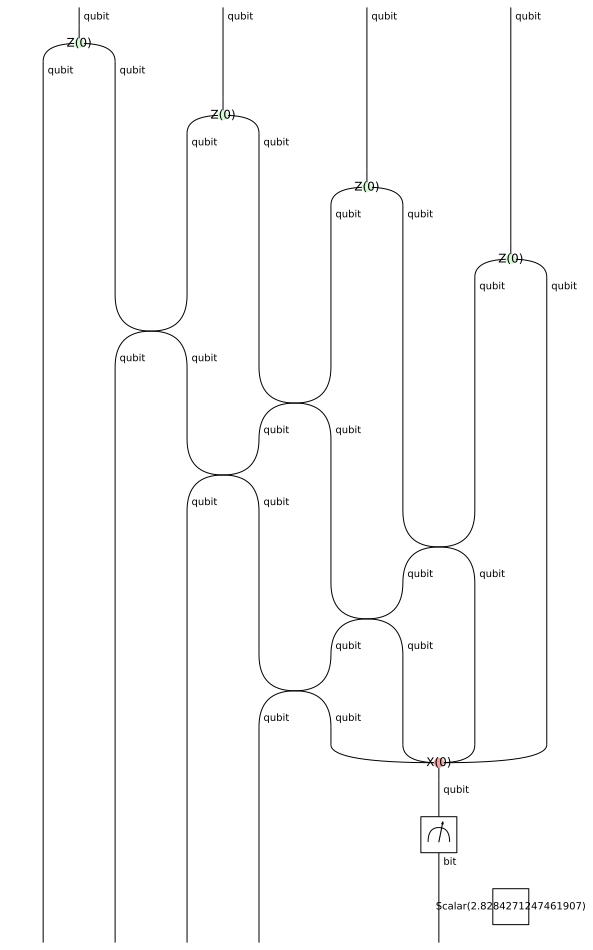

In [5]:
X_detector.draw()

In [6]:
Z_detector = H_ ** 4 >> X_detector >> H_ ** 4 @ Id(bit)

In [7]:
def calculate_fidelity(circuit, expected_state):
    P_s_eq_0 = circuit >> Discard(len(circuit.cod))
    p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

    P_00_and_s_eq_0 = circuit >> expected_state
    p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

    fidelity = p_00_and_s_eq_0 / p_s_eq_0
    return np.sqrt(fidelity.real)

## Calculating the fidelity of Bell state in the post-selected [4,2,2] code, assuming perfect measurements

To calculate fidelity, we use
$$
P(<\!\text{Bell}|\;\mid\;S = 0) = \frac{P(<\!\text{Bell}| \land S = 0)}{P(S = 0)}
$$
where $S$ is the syndrome measurement.

### Using the encoder for the [4,2,2] code, we obtain the logical Bell state:

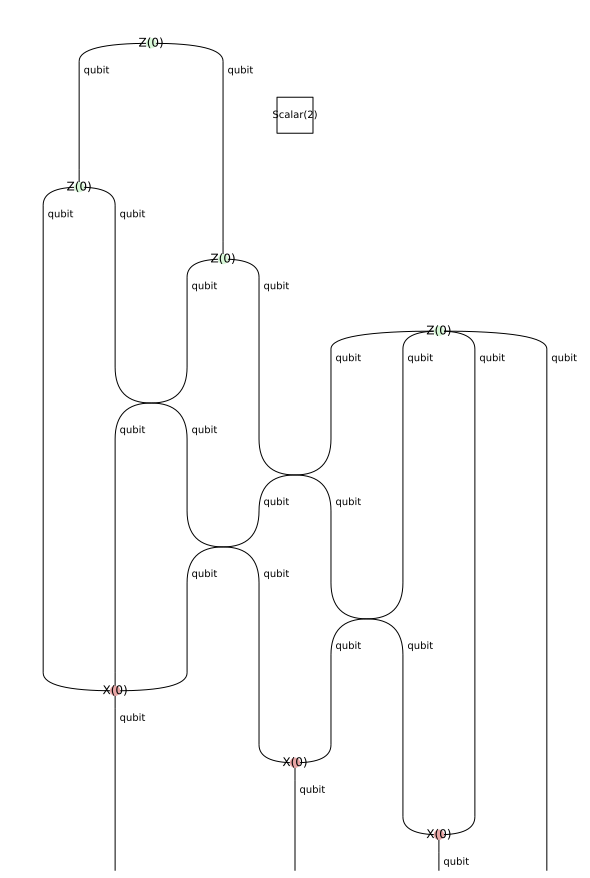

In [8]:
encoder = (
        Z(1, 2) @ Z(1, 2) @ Z(0, 4)
        >> Diagram.permutation([0,2,4,1,5,3,6,7], qubit ** 8)
        >> X(3,1) @ X(2,1) @ X(2,1) @ Id(1)
)

logical_bell = Z(0,2) @ Scalar(2) >> encoder
logical_bell_measurement = logical_bell.dagger()

logical_00 = Z(0,4) @ Scalar(1/np.sqrt(2))
logical_00_measurement = logical_00.dagger()

logical_bell.draw()

### Defining the circuit with probabilistic bit-flips on data qubits

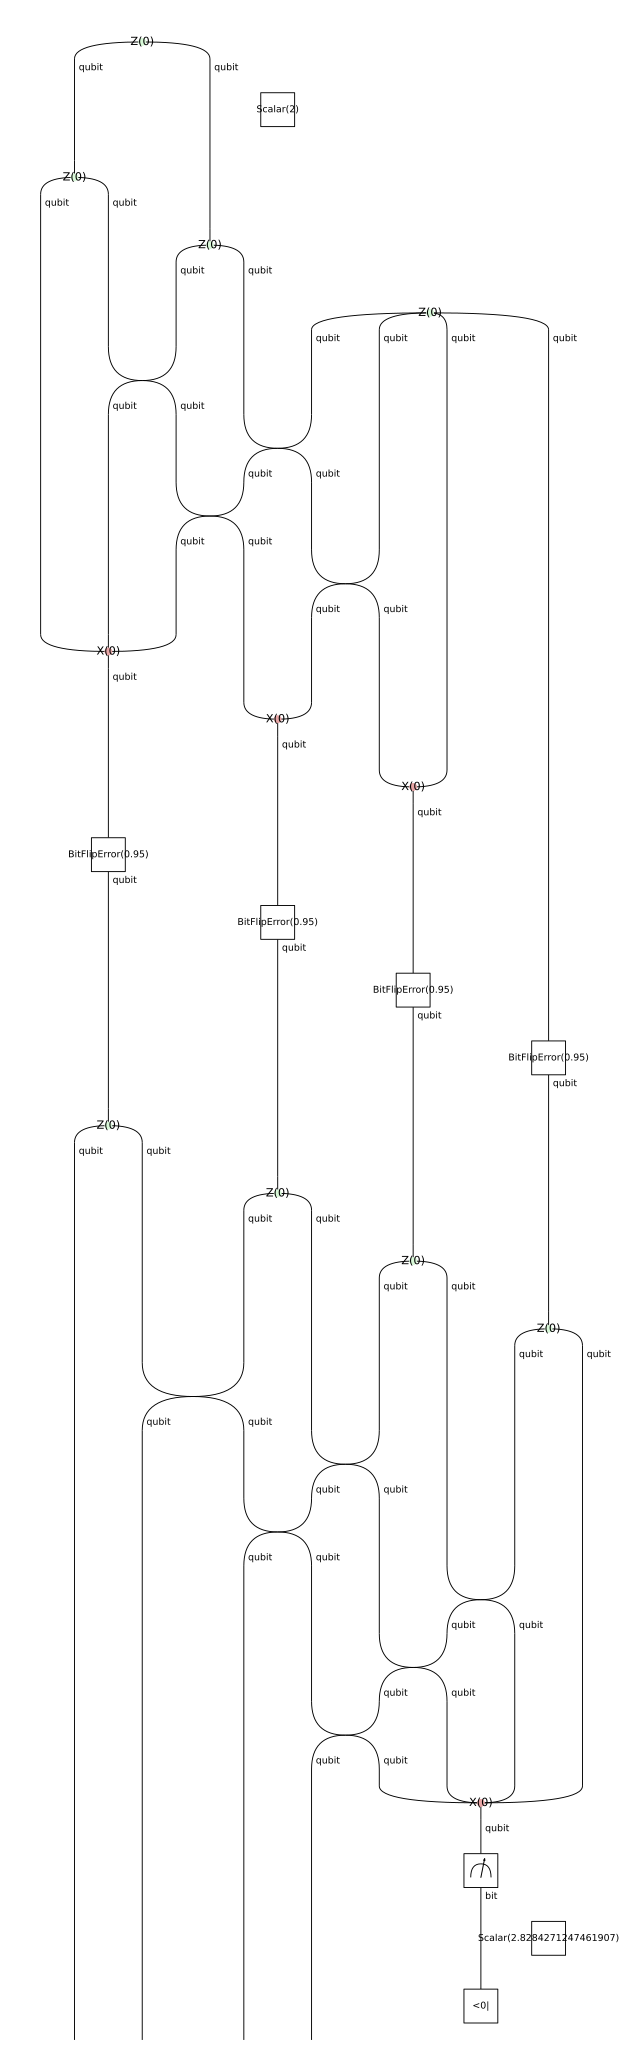

In [9]:
p_error = 0.95
Imperfect_circuit = logical_bell >> BitFlipError(p_error) ** 4 >> X_detector >> Id(4) @ Bit_0

Imperfect_circuit.draw()

In [10]:
(Discard(4) @ Bit_0).dom

optyx.core.channel.Ty(optyx.core.channel.Ob('qubit'), optyx.core.channel.Ob('qubit'), optyx.core.channel.Ob('qubit'), optyx.core.channel.Ob('qubit'), optyx.core.channel.Ob('bit'))

### Computing the fidelity after one round of X error detection

In [11]:
print("Calculated fidelity:", calculate_fidelity(Imperfect_circuit, logical_bell_measurement))

Calculated fidelity: 0.9945355195789249


## Calculating the fidelity for the distributed [4,2,2] code with an imperfect Bell state on the network

### Defining the network Bell state from its density matrix

![Density Matrix](densityMatrix.png)

The state has a fidelity of 96.89(8)% to the |Ψ+⟩ Bell state.
https://www.nature.com/articles/s41586-024-08404-x

In [12]:
bell_density_re = np.array([
    [0.012, 0.014, 0.014, 0.000],
    [0.014, 0.508, 0.475, 0.008],
    [0.014, 0.475, 0.479, 0.009],
    [0.000, 0.008, 0.009, 0.000]
])
bell_density_im = np.exp(1j * np.pi * np.array([
    [0.000, -1.850, -1.825, -0.985],
    [1.850, 0.000, -0.002, -0.902],
    [1.825, 0.002, 0.000, -0.931],
    [0.985, 0.902, 0.931, 0.000]
]))

bell_density = np.multiply(bell_density_re, bell_density_im)
np.set_printoptions(precision=3)
print(bell_density)

[[ 0.012+0.j     0.012+0.006j  0.012+0.007j  0.   -0.j   ]
 [ 0.012-0.006j  0.508+0.j     0.475-0.003j -0.008-0.002j]
 [ 0.012-0.007j  0.475+0.003j  0.479+0.j    -0.009-0.002j]
 [-0.   +0.j    -0.008+0.002j -0.009+0.002j  0.   +0.j   ]]


In [13]:
from discopy import tensor

bell = diagram.Box(name="Bell", dom=diagram.bit ** 2, cod=diagram.bit ** 2, array=bell_density)
bell = diagram.Spider(0, 2, typ=diagram.bit) >> diagram.Id(diagram.bit) @ diagram.Spider(0, 2, typ=diagram.bit) @ diagram.Id(diagram.bit) >> diagram.Diagram.permutation([0,1,3,2], diagram.bit**4) >> diagram.Id(diagram.bit ** 2) @ bell >> diagram.Diagram.permutation([0,2,1,3], diagram.bit**4)

Noisy_bell = CQMap('Physical Bell', bell @ diagram.Scalar(1/0.999), dom=Ty(), cod=qubit ** 2)
Noisy_bell_HH = CQMap('Physical Bell', bell @ diagram.Scalar(1/0.999), dom=Ty(), cod=qubit ** 2) >> H_ @ H_

#### Verifying fidelity

In [14]:
Perfect_Bell = Channel("Perfect Bell", diagram.Spider(0,2,typ=diagram.bit) @ diagram.Scalar(1 / np.sqrt(2)))
Perfect_Bell_Effect = Channel("Perfect Bell Effect", diagram.Spider(2,0,typ=diagram.bit) @ diagram.Scalar(1 / np.sqrt(2)))

print("Calculated fidelity:", (Noisy_bell >> Diagram.id(qubit) @ X_ >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)
print("Calculated fidelity (HH):", (Noisy_bell_HH >> Diagram.id(qubit) @ Z_ >> Perfect_Bell_Effect).double().to_tensor().eval().array.real)

Calculated fidelity: 0.9694600839906553
Calculated fidelity (HH): 0.9694600839906553


### Defining the circuit for the distributed physical implementation

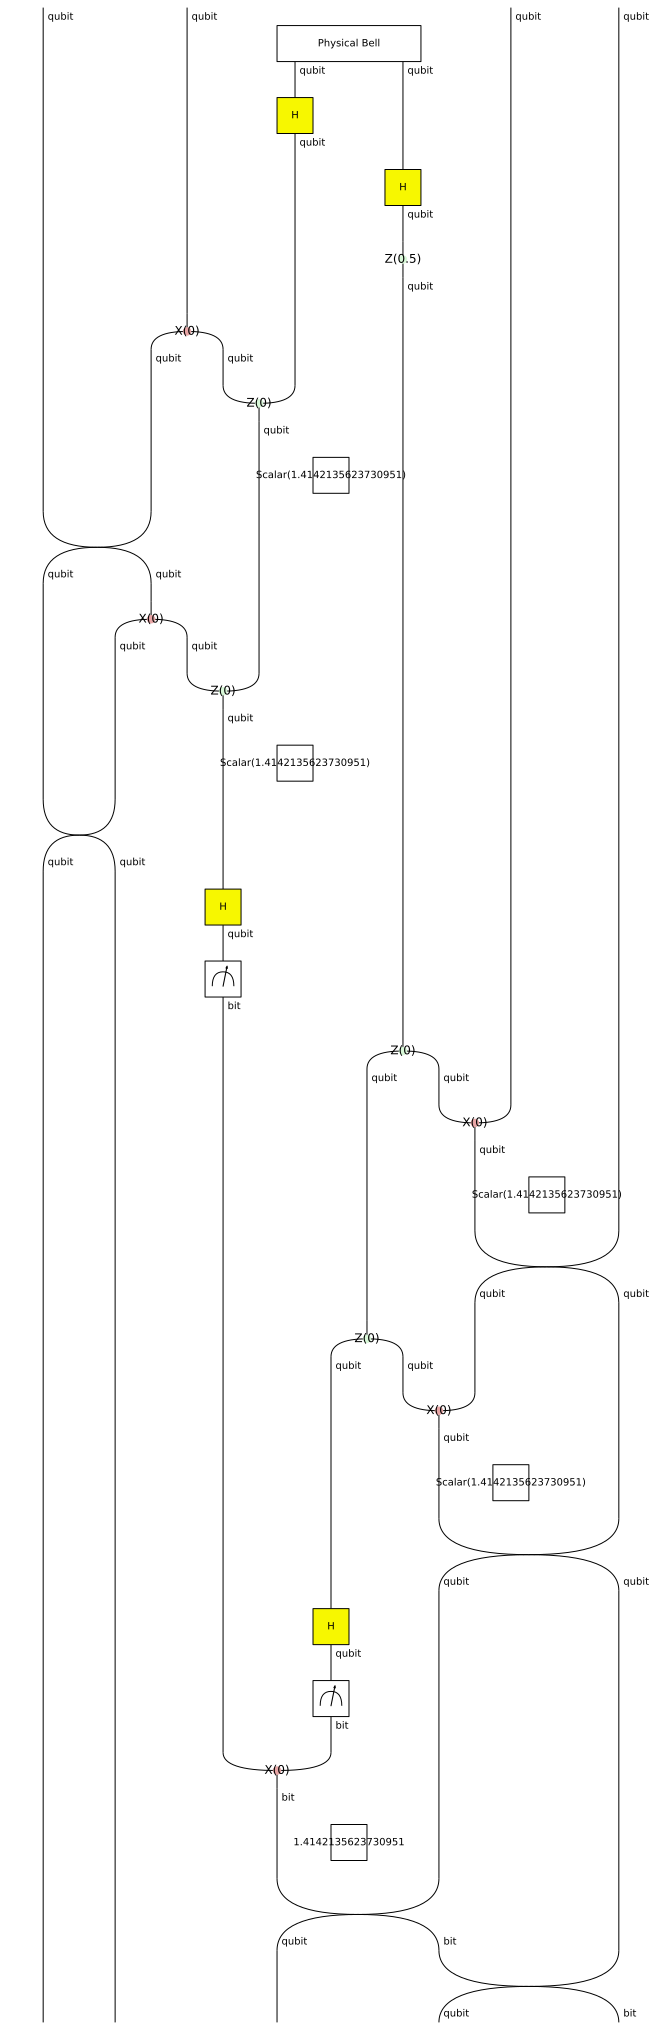

In [15]:

Left_module = (
    Diagram.id(qubit) @ notc >>
    Diagram.permutation([1, 0, 2], qubit ** 3) >>
    Diagram.id(qubit) @ notc >>
    Diagram.permutation([1, 0, 2], qubit ** 3) >>
    Diagram.id(qubit ** 2) @ (H_ >> Measure(1))
)

Right_module = (
    cnot @ Diagram.id(qubit) >>
    Diagram.id(qubit) @ Diagram.swap(qubit, qubit) >>
    cnot @ Diagram.id(qubit) >>
    Diagram.id(qubit) @ Diagram.swap(qubit, qubit) >>
    (H_ >> Measure(1)) @ Diagram.id(qubit ** 2)
)

Left_Z_module = Left_module
Right_Z_module = Right_module
Left_X_module = H_ ** 2 @ Diagram.id(qubit) >> Left_module >> H_ ** 2 @ Diagram.id(bit)
Right_X_module = Diagram.id(qubit) @ H_ ** 2 >> Right_module >> Diagram.id(bit) @ H_ ** 2

from optyx.classical import (
    X as X_bit,
    Scalar as Scalar_bit
)

ClassicalPlus = X_bit(2,1) @ Scalar_bit(np.sqrt(2))

Physical_Z_detector = (
    Diagram.id(qubit ** 2) @ (Noisy_bell_HH >> Diagram.id(qubit) @ Z_) @ Diagram.id(qubit ** 2) >>
    Left_Z_module @ Right_Z_module >>
    Diagram.id(qubit ** 2) @ ClassicalPlus @ Diagram.id(qubit ** 2) >>
    Diagram.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)
)

Physical_X_detector = (
    Diagram.id(qubit ** 2) @ (Noisy_bell_HH >> Diagram.id(qubit) @ Z_) @ Diagram.id(qubit ** 2) >>
    Left_X_module @ Right_X_module >>
    Diagram.id(qubit ** 2) @ ClassicalPlus @ Diagram.id(qubit ** 2) >>
    Diagram.permutation([0,1,3,4,2], qubit ** 2 @ bit @ qubit ** 2)
)

Physical_Z_detector.draw()

In [16]:
def is_causal(diag, verbose=False, rtol=1e-8):
    discard = DiscardChannel(diag.dom).double().to_tensor().eval().array
    unitary_then_discard = (diag >> DiscardChannel(diag.cod)).double().to_tensor().eval().array
    if verbose:
        print(discard, unitary_then_discard)
    return np.allclose(discard, unitary_then_discard, rtol)

d = Noisy_bell

is_causal(d, verbose=True)

1 (1+0j)


True

### Fault-tolerant state preparation

In [17]:
Physical_Logical_00 = Ket_0 ** 4 >> Physical_Z_detector >> Diagram.id(qubit ** 4) @ Bit_0


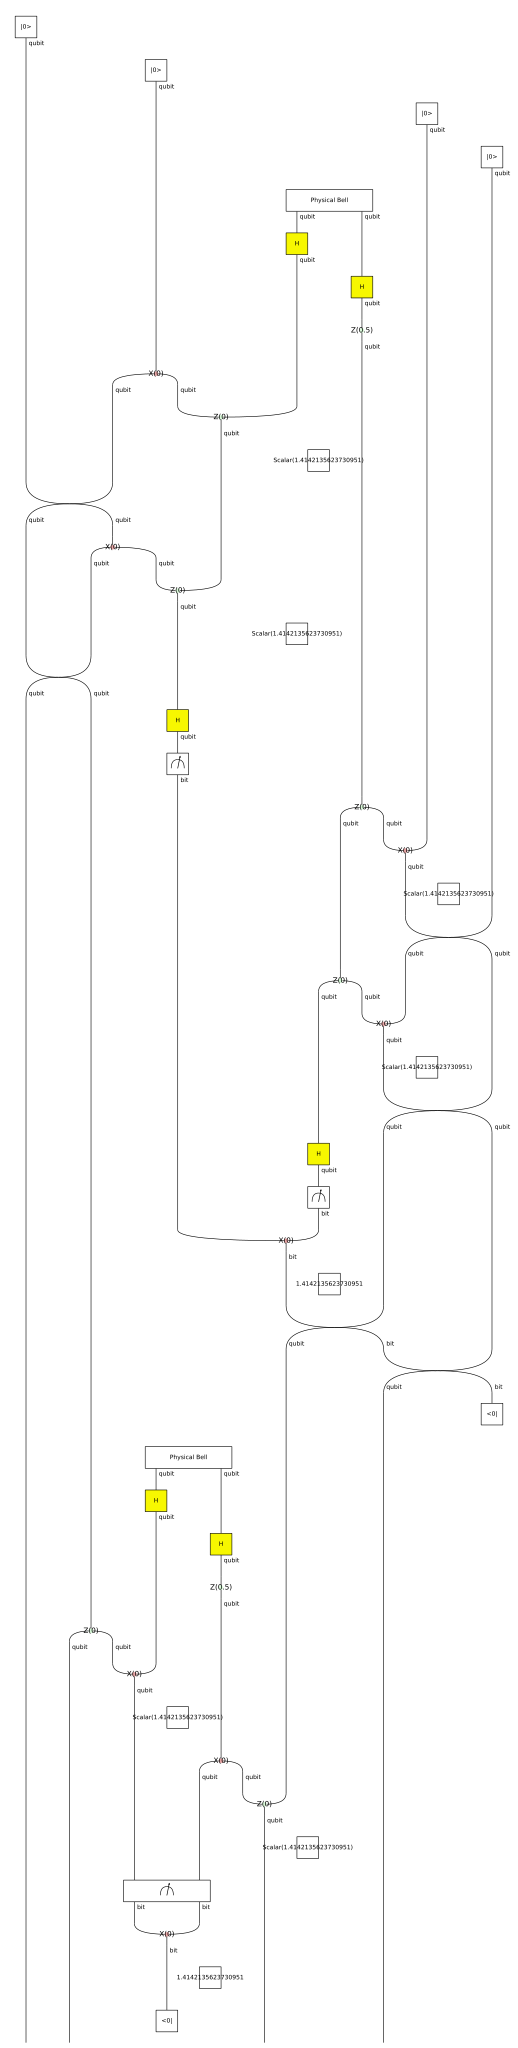

(0.9871372589170971-5.076891896713117e-20j)
(0.9694600839906556-1.5766360938009174e-19j)


In [18]:
Extra_parity_check = Diagram.id(qubit) @ (
    Diagram.id(qubit) @ (Noisy_bell_HH >> Diagram.id(qubit) @ Z_) @ Diagram.id(qubit)
    >> cnot @ notc
    >> Diagram.id(qubit) @ (Measure(2) >> ClassicalPlus >> Bit_0) @ Diagram.id(qubit)
) @ Diagram.id(qubit)

Physical_FT_Logical_00 = Ket_0 ** 4 >> Physical_Z_detector >> Diagram.id(qubit ** 4) @ Bit_0 >> Extra_parity_check
Physical_FT_Logical_00.draw()

nominator = (Physical_FT_Logical_00 >> logical_00_measurement).double().to_tensor().eval().array
denominator = (Physical_FT_Logical_00 >> Discard(4)).double().to_tensor().eval().array
fidelity = nominator / denominator
print(fidelity)

nominator = (Physical_Logical_00 >> logical_00_measurement).double().to_tensor().eval().array
denominator = (Physical_Logical_00 >> Discard(4)).double().to_tensor().eval().array
fidelity = nominator / denominator
print(fidelity)

### Calculating fidelity for Z error detection

In [19]:
0.97**2

0.9409

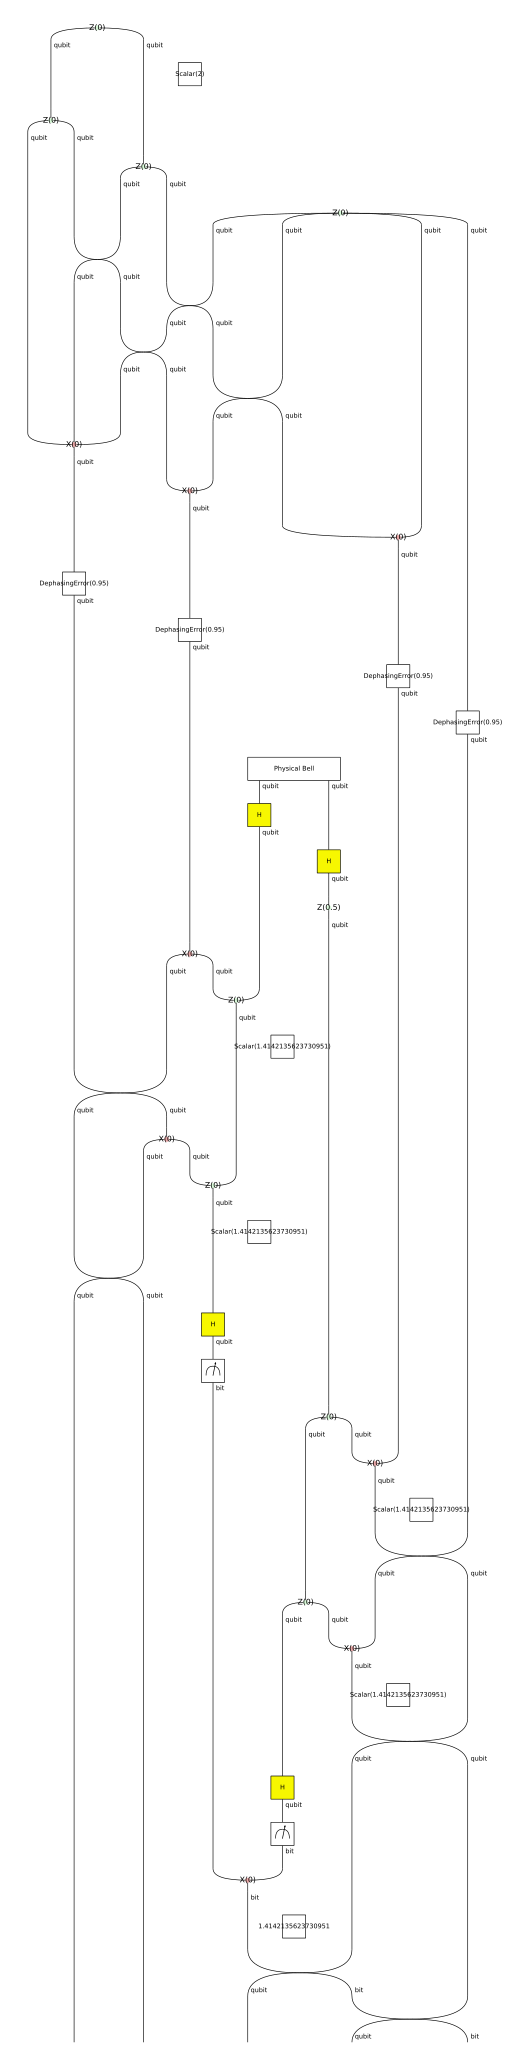

In [20]:
Imperfect_circuit = logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector
Imperfect_circuit.draw()

In [21]:
P_s_eq_0 = Imperfect_circuit >> Discard(4) @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_bell_measurement @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity for Z error detection:", np.sqrt(fidelity.real))

Calculated fidelity for Z error detection: 0.9864120233027301


### Calculating fidelity for a whole round of Z and X error detection

In [22]:
Imperfect_circuit = logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector >> BitFlipError(p_error) ** 4 @ Diagram.id(bit) >> Physical_X_detector @ Diagram.id(bit)

P_s_eq_0 = Imperfect_circuit >> Discard(4) @ Bit_0 @ Bit_0
p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

P_00_and_s_eq_0 = Imperfect_circuit >> logical_bell_measurement @ Bit_0 @ Bit_0
p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

fidelity = p_00_and_s_eq_0 / p_s_eq_0
print("Calculated fidelity a whole round of error detection:", np.sqrt(fidelity.real))

Calculated fidelity a whole round of error detection: 0.9732135897032679


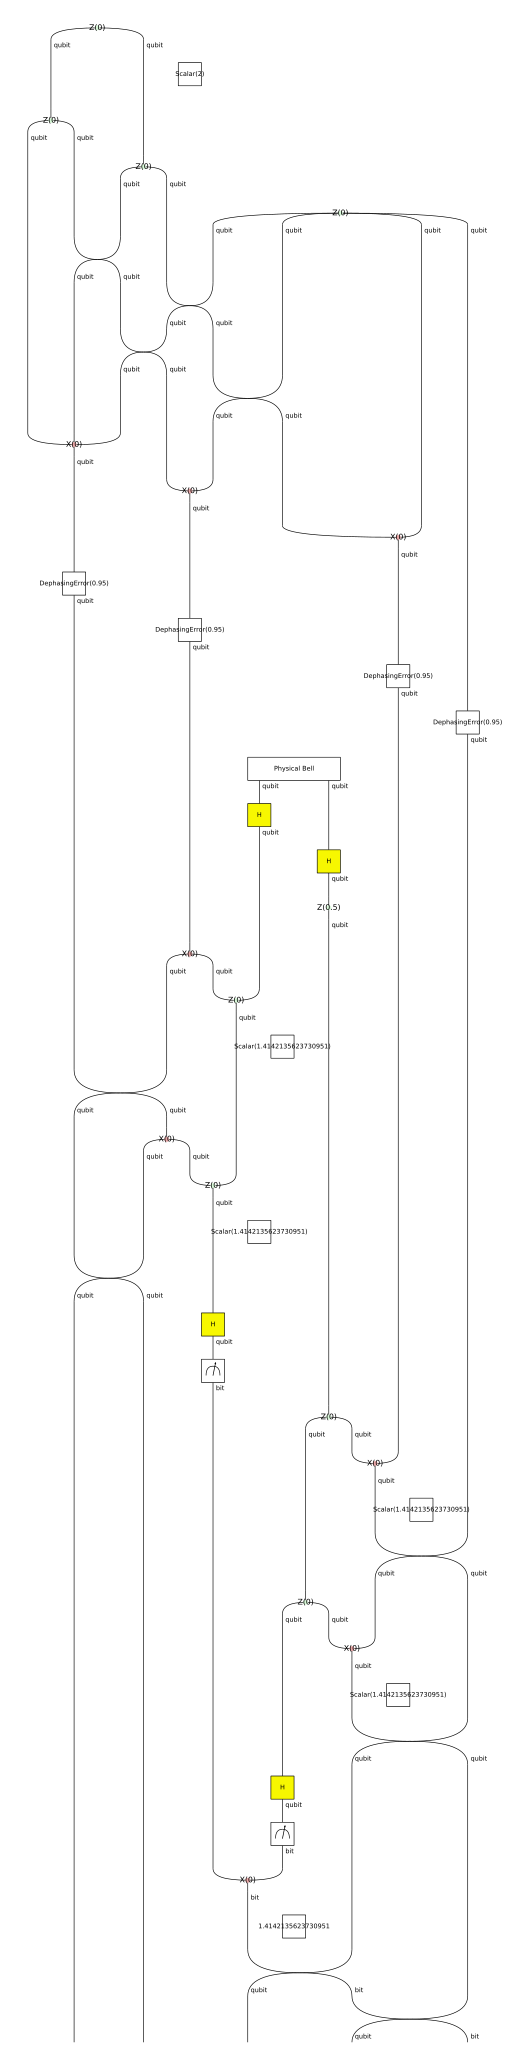

In [23]:
Imperfect_circuit = logical_bell >> DephasingError(p_error) ** 4 >> Physical_Z_detector
Imperfect_circuit.draw()

## Two-qubit bit-flip with a two-qubit phase-flip repetition code

In [24]:
(Ket_0 ** 4 >> Physical_Z_detector >> DiscardChannel(qubit ** 4 @ bit)).double().to_tensor().eval().array

array(1.+0.j)

In [25]:
(Ket_0 ** 4 >> Physical_Z_detector >> logical_00_measurement @ Bit_0).double().to_tensor().eval().array

array(0.485+0.j)

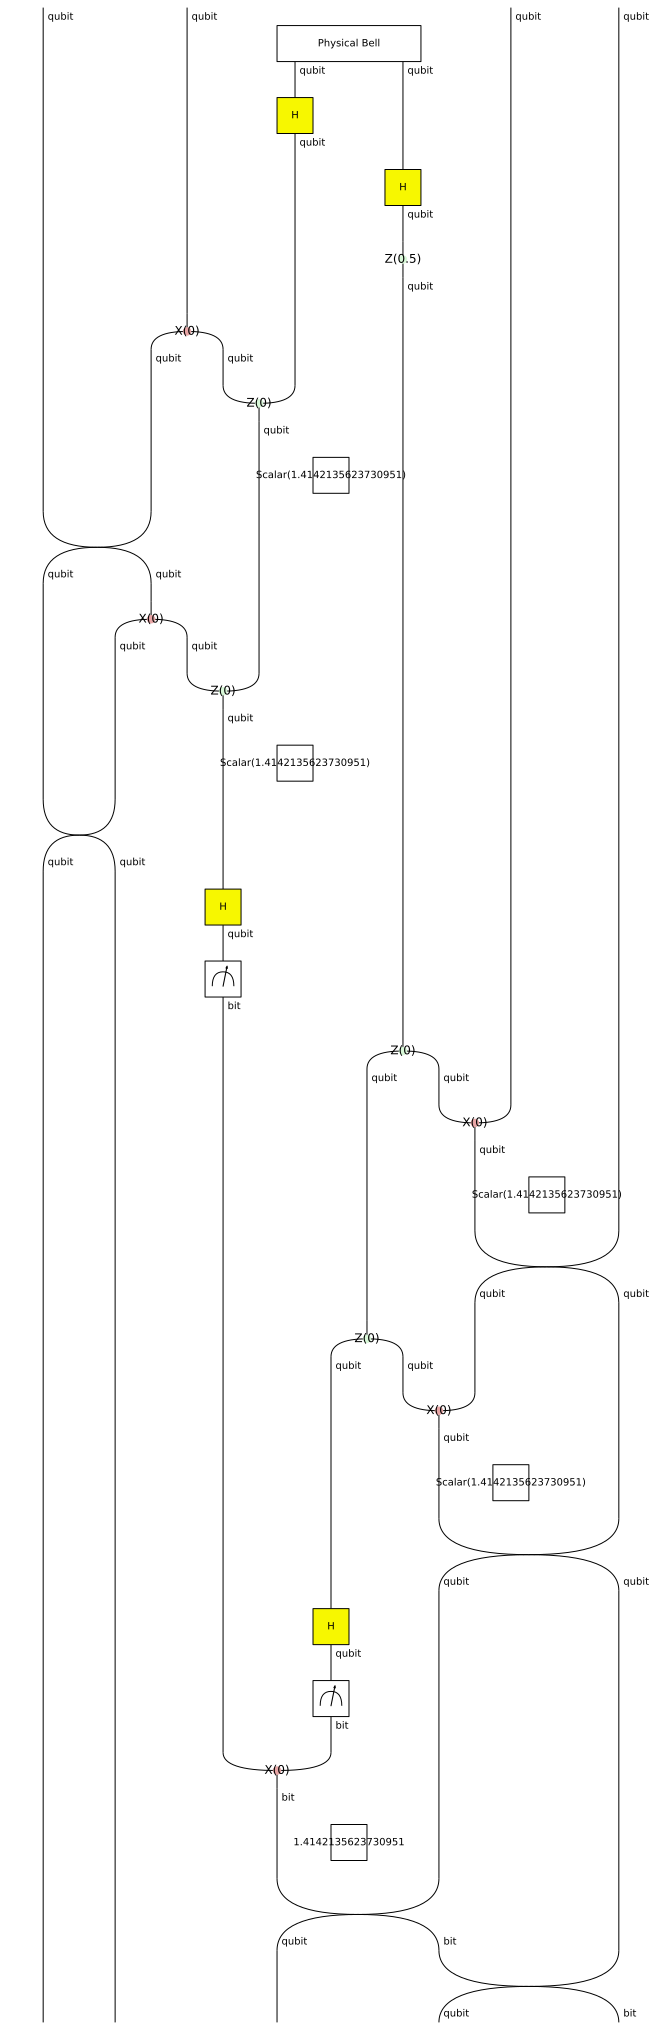

In [26]:
Physical_Z_detector.draw()

In [27]:
def fidelity(input_state, p_error=0.95, n_rounds=1):
    Circuit = input_state
    for round in range(n_rounds):
        if round % 2:
            Circuit >>= BitFlipError(p_error) ** len(input_state.cod) >> Physical_X_detector >> Circuit.id(input_state.cod) @ Bit_0
        else:
            Circuit >>= DephasingError(p_error) ** len(input_state.cod) >> Physical_Z_detector >> Circuit.id(input_state.cod) @ Bit_0
    P_s_eq_0 = Circuit >> DiscardChannel(input_state.cod)
    p_s_eq_0 = P_s_eq_0.double().to_tensor().eval().array

    P_00_and_s_eq_0 = Circuit >> input_state.dagger()
    p_00_and_s_eq_0 = P_00_and_s_eq_0.double().to_tensor().eval().array

    fidelity = p_00_and_s_eq_0 / p_s_eq_0
    return np.sqrt(fidelity.real)

fidelity(logical_bell, 0.95, 2)

0.973213589703268

### Plotting the improvement in fidelity after error detection.

In [28]:
xs = np.linspace(0.9, 1, 10)
ys = [fidelity(logical_bell, error) for error in xs]
yys = [fidelity(logical_bell, error, n_rounds=2) for error in xs]

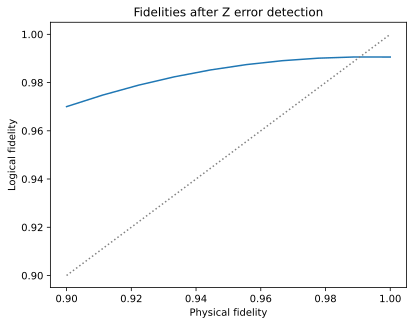

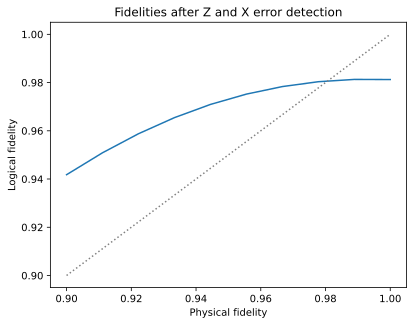

In [29]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)
plt.plot(xs, xs, linestyle=':', color='gray')

plt.title("Fidelities after Z error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()

plt.plot(xs, yys)
plt.plot(xs, xs, linestyle=':', color='gray')

plt.title("Fidelities after Z and X error detection")
plt.xlabel("Physical fidelity")
plt.ylabel("Logical fidelity")
plt.show()